In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [2]:
# Dataset:
# Seoul Bike Sharing Demand [Dataset]. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [3]:
dataset_cols=['Rented Bike Count','Hour','Temperature(°C)','Humidity(%)','Wind','Visibility','Dew point temperature','Solar Radiation','Rainfall','Snowfall','Functioning Day']

In [4]:
import os
os.chdir(r"C:\Users\conso\Desktop\Python")
df=pd.read_csv("SeoulBikeData.csv").drop(['Date','Holiday','Seasons'], axis=1) #axis=1 means to drop it from the columns

In [5]:
df.columns=dataset_cols
df['Functioning Day']=(df['Functioning Day']=='Yes').astype(int)
df=df[df['Hour']==12]
df=df.drop(['Hour'], axis=1) #we take only the rows corresponding to noon

In [8]:
df.head()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Functioning Day
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


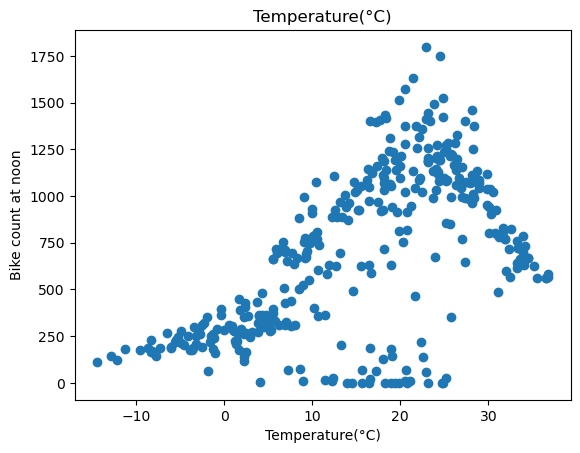

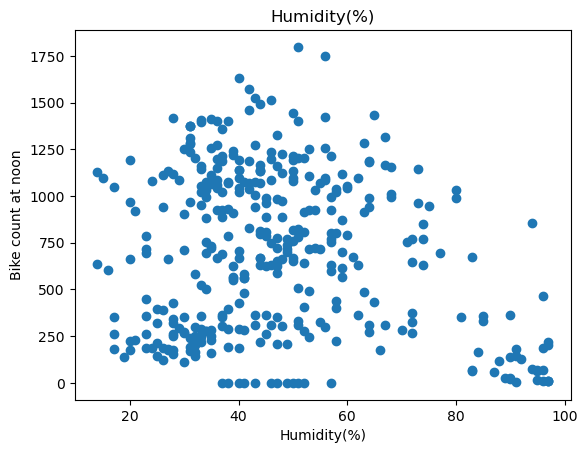

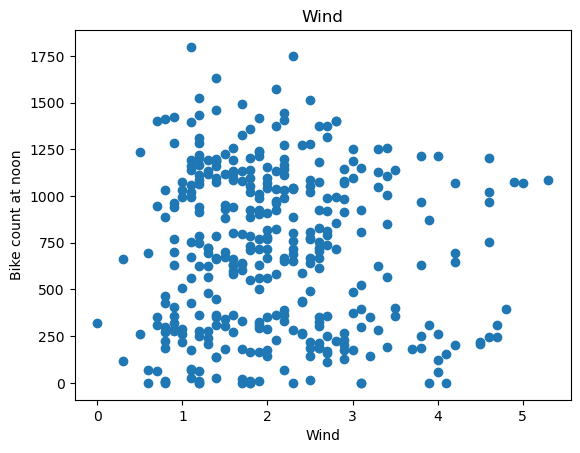

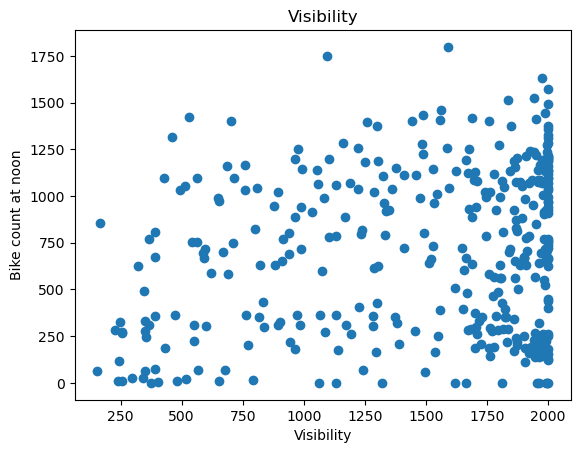

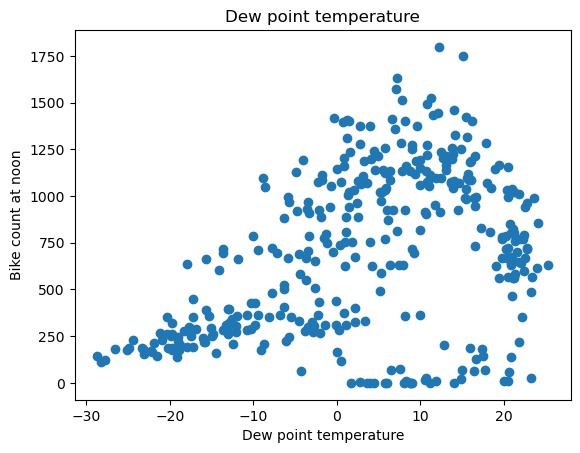

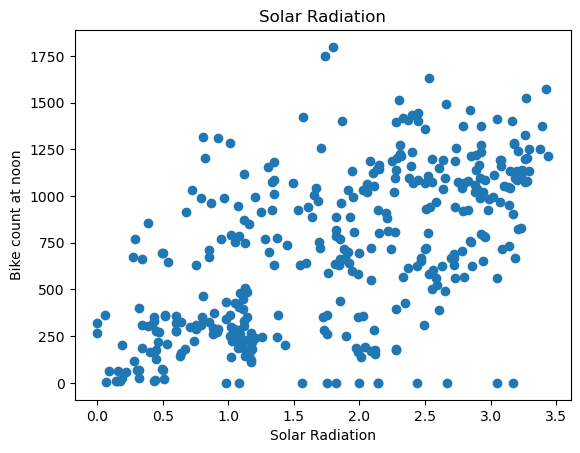

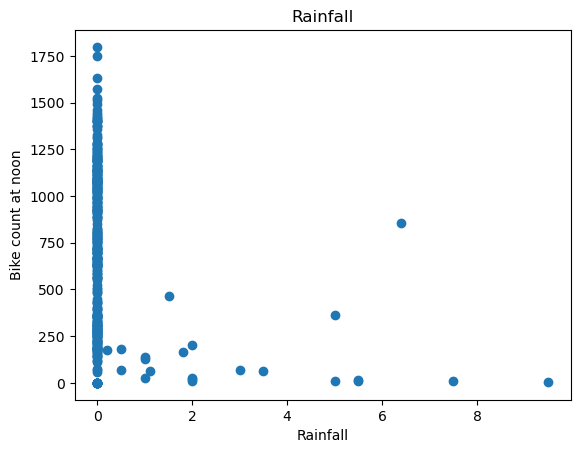

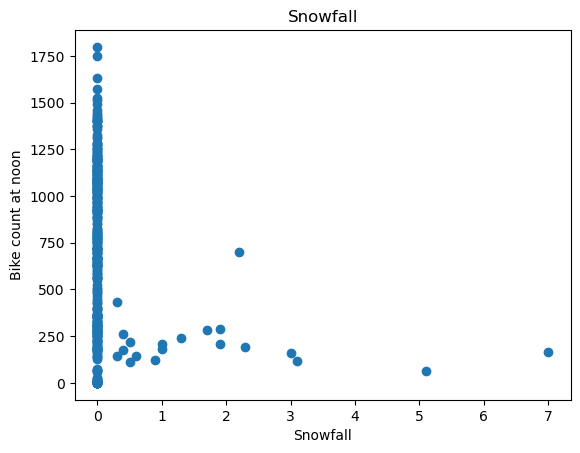

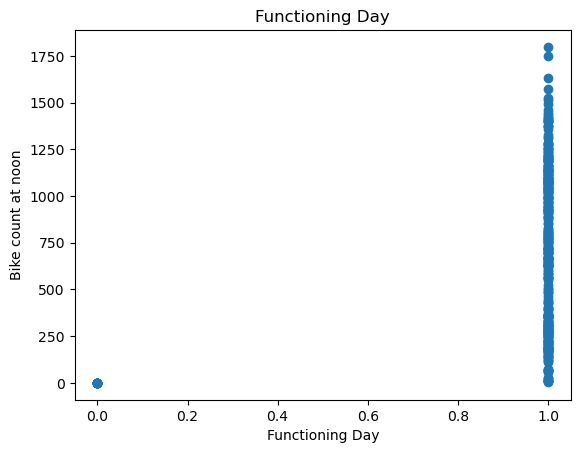

In [9]:
for label in df.columns[1:]:
    plt.scatter(df[label], df['Rented Bike Count'])
    plt.title(label)
    plt.ylabel('Bike count at noon')
    plt.xlabel(label)
    plt.show()

In [6]:
df=df.drop(['Wind','Visibility','Functioning Day'],axis=1)

In [11]:
df.head()

,Rented Bike Count,Temperature(°C),Humidity(%),Dew point temperature,Solar Radiation,Rainfall,Snowfall
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [12]:
#Train/Valid/test dataset

In [7]:
train, val, test=np.split(df.sample(frac=1), [int(0.6*len(df)),int(0.8*len(df))])

In [8]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe=copy.deepcopy(dataframe)
    if x_labels is None:
        X=dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels)==1:
            X=dataframe[x_labels].values.reshape(-1,1)
        else:
            X=dataframe[x_labels].values
        
    y=dataframe[y_label].values.reshape(-1,1)
    data=np.hstack((X,y))
    
    return data, X, y

In [9]:
_, X_train_temp, y_train_temp=get_xy(train, "Rented Bike Count", x_labels=['Temperature(°C)'])
_, X_val_temp, y_val_temp=get_xy(val, "Rented Bike Count", x_labels=['Temperature(°C)'])
_, X_test_temp, y_test_temp=get_xy(test, "Rented Bike Count", x_labels=['Temperature(°C)'])

In [10]:
temp_reg=LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [47]:
print(temp_reg.coef_, temp_reg.intercept_)
#R^2 (if close to 1 temperature it's probably a good predictor)
temp_reg.score(X_test_temp,y_test_temp)

[[22.43605593]] [344.70811177]


0.18426050349091572

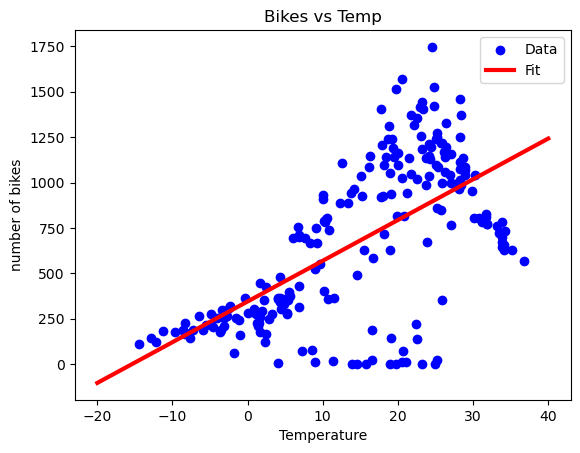

In [48]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,temp_reg.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('number of bikes')
plt.xlabel('Temperature')
plt.show()

In [49]:
#Multiple linear regression

In [11]:
_, X_train_all, y_train_all=get_xy(train, "Rented Bike Count", x_labels=df.columns[1:])
_, X_val_all, y_val_all=get_xy(val, "Rented Bike Count", x_labels=df.columns[1:])
_, X_test_all, y_test_all=get_xy(test, "Rented Bike Count", x_labels=df.columns[1:])

In [39]:
all_reg=LinearRegression()
all_reg.fit(X_train_all, y_train_all)
y_pred_lr=all_reg.predict(X_test_all)
all_reg.score(X_test_all,y_test_all)

0.4247907172052202

In [12]:
#regression with Neural Network
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [70]:
temp_nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1) #one unit, without activation function makes a Neural Network linear
])


In [71]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

In [72]:
history=temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

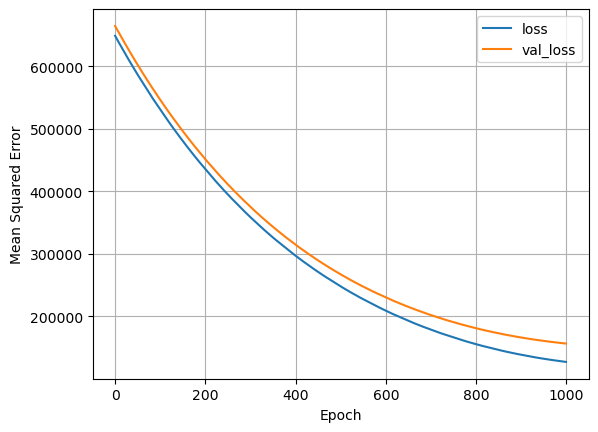

In [73]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


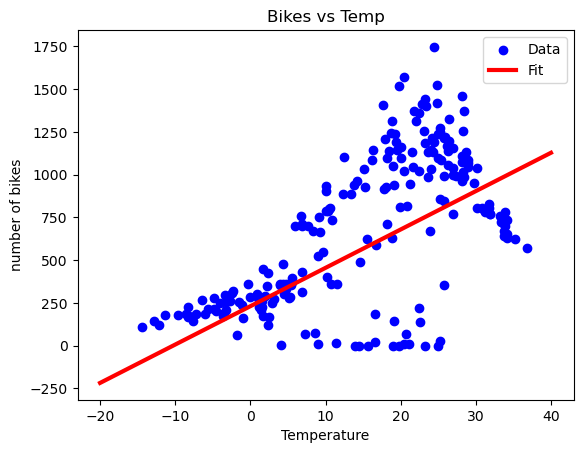

In [62]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,temp_nn_model.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('number of bikes')
plt.xlabel('Temperature')
plt.show()

In [75]:
all_normalizer=tf.keras.layers.Normalization(input_shape=(len(df.columns[1:]),),axis=1)
all_normalizer.adapt(X_train_all)

In [76]:
all_nn_model=tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(1) #one unit, without activation function makes a Neural Network linear
])

In [77]:
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

In [79]:
history=all_nn_model.fit(
    X_train_all, y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_all, y_val_all)
)

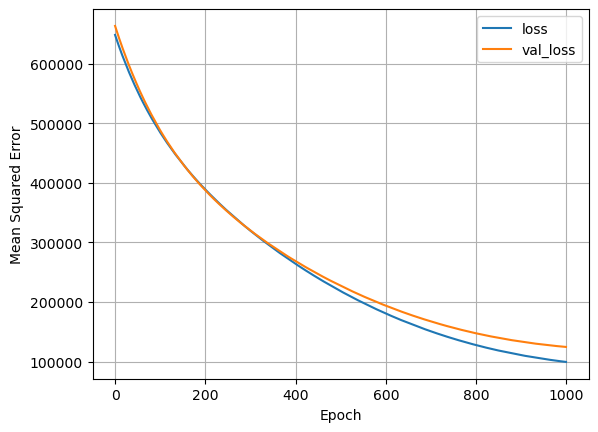

In [80]:
plot_loss(history)

In [28]:
# Neural Network
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
     tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [29]:
history=nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)


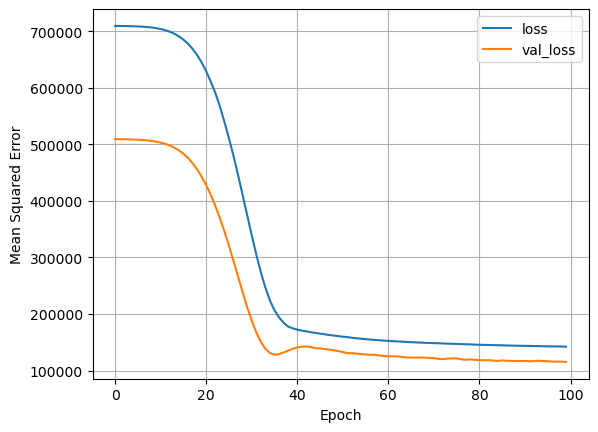

In [30]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


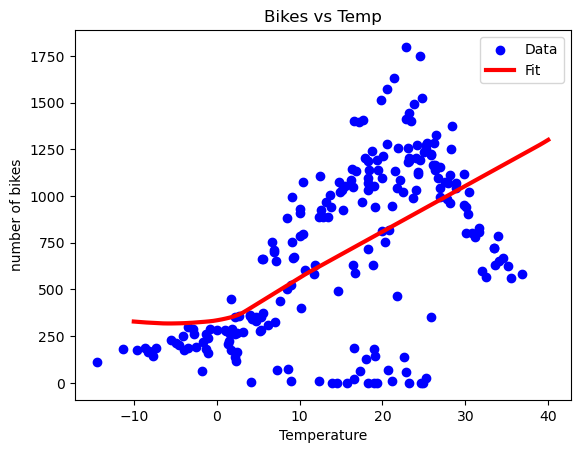

In [32]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x=tf.linspace(-10,40,100)
plt.plot(x,nn_model.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('number of bikes')
plt.xlabel('Temperature')
plt.show()

In [83]:
# Neural Network
all_normalizer=tf.keras.layers.Normalization(input_shape=(6,),axis=-1)
all_normalizer.adapt(X_train_all)

nn_model=tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [84]:
history=nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

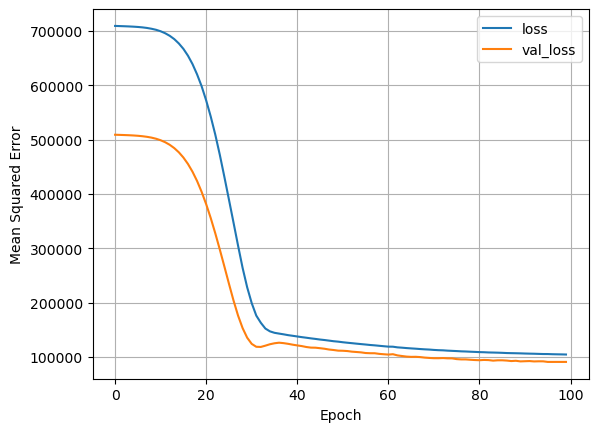

In [85]:
plot_loss(history)

In [86]:
#caluculate the Mean Squared Error for both linear reg and nn
y_pred_lr=all_reg.predict(X_test_all)
y_pred_nn=nn_model.predict(X_test_all)

3/3 [==============================] - 0s 3ms/step


In [87]:
def MSE(y_pred, y_real):
    return (np.square(y_pred-y_real)).mean()

In [88]:
MSE(y_pred_lr, y_test_all)

84617.3358187082

In [89]:
MSE(y_pred_nn, y_test_all)

88794.78583303696

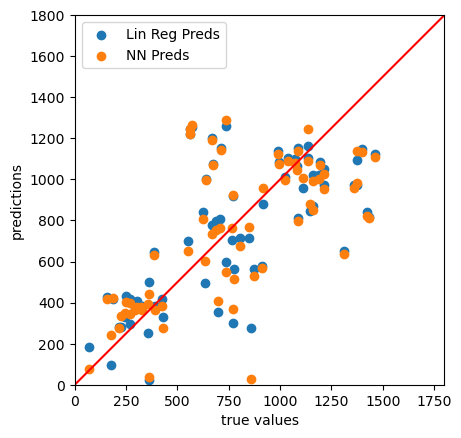

In [90]:
ax=plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label='Lin Reg Preds')
plt.scatter(y_test_all, y_pred_nn, label='NN Preds')
plt.xlabel('true values')
plt.ylabel('predictions')
lims=[0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_=plt.plot(lims, lims, c='red')